## Importing Libraries

In [101]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import random

### Setting up seed

In [102]:
random.seed(3116)

### Utilities functions for logistic regression

In [103]:
def _sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [104]:
def y_prediction(X_data, beta):
    beta = np.dot(X_data, beta)
    y_predict = _sigmoid(beta)
    return y_predict

In [105]:
def loss(X_data, Y_data, beta):
    y_predict = y_prediction(X_data, beta)    
    loss = (Y_data * np.log(y_predict)) + ((1 - Y_data)*np.log(1 - y_predict))
    loss = sum(loss)
    return loss[0]

In [106]:
def loss_full(X_data, Y_data, beta):
    y_predict = y_prediction(X_data, beta)    
    loss = (Y_data * np.log(y_predict)) + ((1 - Y_data)*np.log(1 - y_predict))
    loss = sum(loss)
    return loss[0]

In [107]:
def calculate_aic(X,y,betas,num_params):
    L = loss(X,y,betas)
    return -2.0 * L + 2.0 * num_params


In [108]:
def derivativeEq(X_data, Y_data,beta):
    y_predict = y_prediction(X_data , beta)
    y_calculated = Y_data - y_predict
    derivative0 = np.dot(X_data.T, y_calculated)
    
    derivative = np.multiply(-2, derivative0)
    return derivative

In [109]:
#function is adding bias of 1's and extracting the labels
def biasandlabels(train_data, test_data): 
    
    test_data.insert(loc=0,column='bias',value=np.ones(len(test_data)))
    train_data.insert(loc=0,column='bias',value=np.ones(len(train_data)))
        
    return train_data,test_data

### Function to convert dataset to mini Batches

In [110]:
# function to create a list containing mini-batches 
def create_mini_batches(X, y, batch_size): 
    mini_batches = [] 
    y = y.reshape(-1,1)
    data = np.hstack((X, y))
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
  
    for i in range(n_minibatches + 1): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    if data.shape[0] % batch_size != 0: 
        mini_batch = data[i * batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    return mini_batches 

### Logistic Regression Function with mini batch gradient ascent

In [111]:
def logistic_regression_mini(X_data, Y_data, X_test, Y_test):
    log_loss =[]
    mse = []
    beta = np.zeros((X_data.shape[1], 1)) 
    updated_loss = loss(X_data, Y_data, beta)
    lr = 0.001
    batch_size = 256
    
    for i in range(100):
        
        mini_batches = create_mini_batches(X_data, Y_data, batch_size)
        
        for mini_batch in mini_batches: 
            X_mini, y_mini = mini_batch
            
            y_predict = y_prediction(X_mini, beta)
            beta = beta + (lr*np.dot(X_mini.T,  y_mini - y_predict))
            previous_loss = updated_loss
            updated_loss = loss_full(X_mini,y_mini,beta)
        
        y_hat = y_prediction(X_test, beta)
        mse.append(np.square(np.subtract(Y_test,y_hat)).mean())
        log_loss.append(np.absolute(loss(X_test,Y_test,beta)))

        if((updated_loss - previous_loss) <= 0.00001):
            break
    
    return log_loss

### Function to split dataset into train,test set as mentioned in exercise along with normalization

In [112]:
def split(df):
    df = pd.get_dummies(df)
    df = df.drop(['y_no'],axis=1)
    df_label = df['y_yes'] 
    df =(df-df.mean())/df.std() 
    df['y_yes'] = df_label
    
    shuffle = df.sample(frac=1)
    train_size = int(0.8*len(df))
    df_train = shuffle[:train_size]
    df_test = shuffle[train_size:]
    
    Xtrain = df_train.drop(['y_yes'], axis = 1)
    Ytrain = df_train['y_yes'].to_numpy()
    
    Xtest = df_test.drop(['y_yes'], axis = 1)
    Ytest = df_test['y_yes'].to_numpy()
    
    #adding bias to data
    Xtrain, Xtest = biasandlabels(Xtrain, Xtest)

    return Xtrain, Ytrain, Xtest, Ytest

### Loading dataset

In [113]:
data1 = pd.read_csv('bank.csv', delimiter= ';', header=0)

### Checking missing or Null values

In [114]:
null_data = data1.isnull().any().sum()
na_data = data1.isna().any().sum()

print("Null Data: ",null_data )
print("Missing Data: ",na_data )

Null Data:  0
Missing Data:  0


In [115]:
Xtrain, Ytrain, Xtest, Ytest = split(data1)

In [116]:
print (Xtrain.shape)
print (Xtest.shape)
print (Ytrain.shape)
print (Ytest.shape)

(3616, 52)
(905, 52)
(3616,)
(905,)


### Running simple logistic regression with mini batch gradient ascent without backward search

In [117]:
log_loss  = logistic_regression_mini(Xtrain, Ytrain, Xtest, Ytest)

### Loglikelihood Loss on Test Set

In [118]:
log_loss[-1:]

[156.23738915731911]

### Plotting Loglikelihood loss 

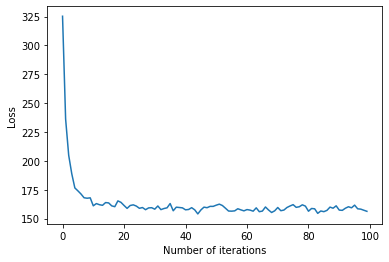

In [119]:
# visualising gradient descent 
plt.plot(log_loss) 
plt.xlabel("Number of iterations") 
plt.ylabel("Loss") 
plt.show() 

## Now we will run backward selection search to find model features that will give us minimum Aic.

### Logistic regression for backward search

In [120]:
def logistic_regression_backward(X_data, Y_data):
   
    beta = np.zeros((X_data.shape[1], 1)) 
    lr = 0.001
    batch_size = 256

    for i in range(100):
        mini_batches = create_mini_batches(X_data, Y_data, batch_size)
        for mini_batch in mini_batches: 
            X_mini, y_mini = mini_batch
            y_predict = y_prediction(X_mini, beta)
            beta = beta + (lr*np.dot(X_mini.T,  y_mini - y_predict))
    
    return beta

### Backward Search 

In [121]:
def backward_search(Xtrain, Ytrain, Xvalid, Yvalid):
    N, M = Xtrain.shape
    print(f"--- Backward Search Running ---")
    print(f"Total {M} features in dataset!!!\n")
    
    V = set(range(M))    
    betas = logistic_regression_backward(Xtrain[:, list(V)], Ytrain)
    
    e_train = calculate_aic(Xtrain[:,list(V)], Ytrain, betas, len(V))
    e_valid = calculate_aic(Xvalid[:, list(V)], Yvalid, betas, len(V))
#     print(e_train,e_valid)
    
    while True:
        print(f"Aic(train):{e_train:.2f} Aic(valid):{e_valid:.2f} vars:{V}\n")
        
        vbest = None
        for v in V:
            Vdash = list(V-{v})
            betas_new = logistic_regression_backward(Xtrain[:,Vdash],Ytrain)
            err = calculate_aic(Xvalid[:,Vdash], Yvalid, betas_new, len(Vdash))
            
            if err < e_valid:
                
                vbest = v
                e_valid = err
                e_train = calculate_aic(Xtrain[:, Vdash], Ytrain, betas_new, len(Vdash))
                print(f"\n Reduced Aic(train):{e_train:.2f} Aic(valid):{e_valid:.2f} vars:{V}\n")

                
        if vbest is None:
            break
        V = V-{vbest}
        return V

### Running backward search to select model feature which minimizes aic.

In [122]:
results = backward_search(Xtrain.to_numpy(), Ytrain, Xtest.to_numpy(), Ytest)

--- Backward Search Running ---
Total 52 features in dataset!!!

Aic(train):1402.15 Aic(valid):423.16 vars:{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}


 Improved Aic(train):1377.81 Aic(valid):415.24 vars:{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}


 Improved Aic(train):1088.45 Aic(valid):354.89 vars:{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}



### Now we will find and remove column from dataset that was not selected by backward search

In [124]:
print(results)
orignal_cols = set(range(Xtrain.shape[1]))
print(f"\nColumn to remove {orignal_cols-results}")

{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}

Column to remove {4}


In [125]:
X_new=Xtrain.loc[:, Xtrain.columns != 'duration']
X_new_t=Xtest.loc[:, Xtest.columns != 'duration']

### Now again running the logistic regression with feature set as selected by backward search

In [126]:
log_loss2 = logistic_regression_mini(X_new, Ytrain, X_new_t, Ytest)

### Final Test Loss

In [127]:
log_loss2[-1]

127.15963644804717

### Plotting Loglikelihood loss 

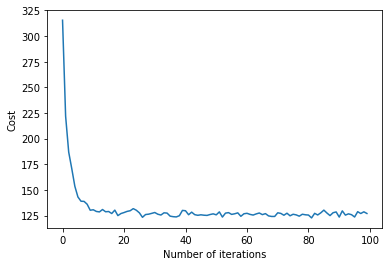

In [128]:
# visualising gradient descent 
plt.plot(log_loss2) 
plt.xlabel("Number of iterations") 
plt.ylabel("Cost") 
plt.show() 

##### When we run simple logistic regression algorithm with full dataset features, we got loss as 156.23. But when we run logistic regression algorithm with feature set selected by backward search, we got loss 127.15. This shows that backward selection search help us to select feautures that will make algorithm to converge better and reduce loss